# Cosmic Extractor v2.1
Because I had to copy it to a new file.

In [7]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from scipy import ndimage

from astropy.io import fits
from astropy.visualization import ZScaleInterval, ImageNormalize # For displaying the preproc images

import os
import re
import glob
import json
from pathlib import Path
import time

import joincosmics

In [8]:
# Took this from DESIspec.
def parse_sec_keyword(value):
    m = re.search(r'\[(\d+):(\d+)\,(\d+):(\d+)\]', value)
    if m is None:
        m = re.search(r'\[(\d+):(\d+)\, (\d+):(\d+)\]', value)
        if m is None :
            raise ValueError('unable to parse {} as [a:b, c:d]'.format(value))

    xmin, xmax, ymin, ymax = tuple(map(int, m.groups()))

    return np.s_[ymin - 1:ymax, xmin - 1:xmax]

# Subtracts off the bias overscan region to normalize the four quadrants.
def subtract_bias(img, camera, hdus):
    # Camera defines which camera to use, e.x. "R5"
    quads = ["A", "B", "C", "D"]
    corners = {}

    for q in quads:
        # Gets the data from the overscan region and subtracts the median from the data region.
        # More accurate would be to median each row or column etc but this is quick and dirty.
        o_i = parse_sec_keyword(hdus[camera].header["ORSEC" + q])
        d_i = parse_sec_keyword(hdus[camera].header["DATASEC" + q])
        overscan = img[o_i].copy()
        corners[q] = img[d_i] - np.median(overscan)
        
    # Smash the corners back together to make the large image.
    lower = np.concatenate((corners["A"], corners["B"]), axis=1)
    higher = np.concatenate((corners["C"], corners["D"]), axis=1)
    return np.concatenate((lower, higher), axis=0)

def pretty_disp(img):
    # Normalization to display the image nicer.
    zscale = ZScaleInterval()
    norm = ImageNormalize(img, zscale)

    fig, ax = plt.subplots(1, 1, figsize=(14, 28), tight_layout=True)
    ax.imshow(img, cmap='gray', origin="lower", interpolation="none", norm=norm)

In [9]:
# Time to make some dark medians.
# d = "20200209"
# ims = ["00047922", "00047911", "00047914", "00047920", "00047940", "00047909", "00047935"]

d = "20200608"  #450s
ims = ["00056648", "00056644", "00056645", "00056646", "00056647"]

ROOT = Path('/project/projectdirs/desi/spectro/data/')
ROOT_PRE = Path('/project/projectdirs/desi/spectro/redux/daily/preproc/')

00056648
00056644
00056645
00056646
00056647
Loaded


Text(0.5,1,'Dark Median 600s Camera R3')

/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/conda/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


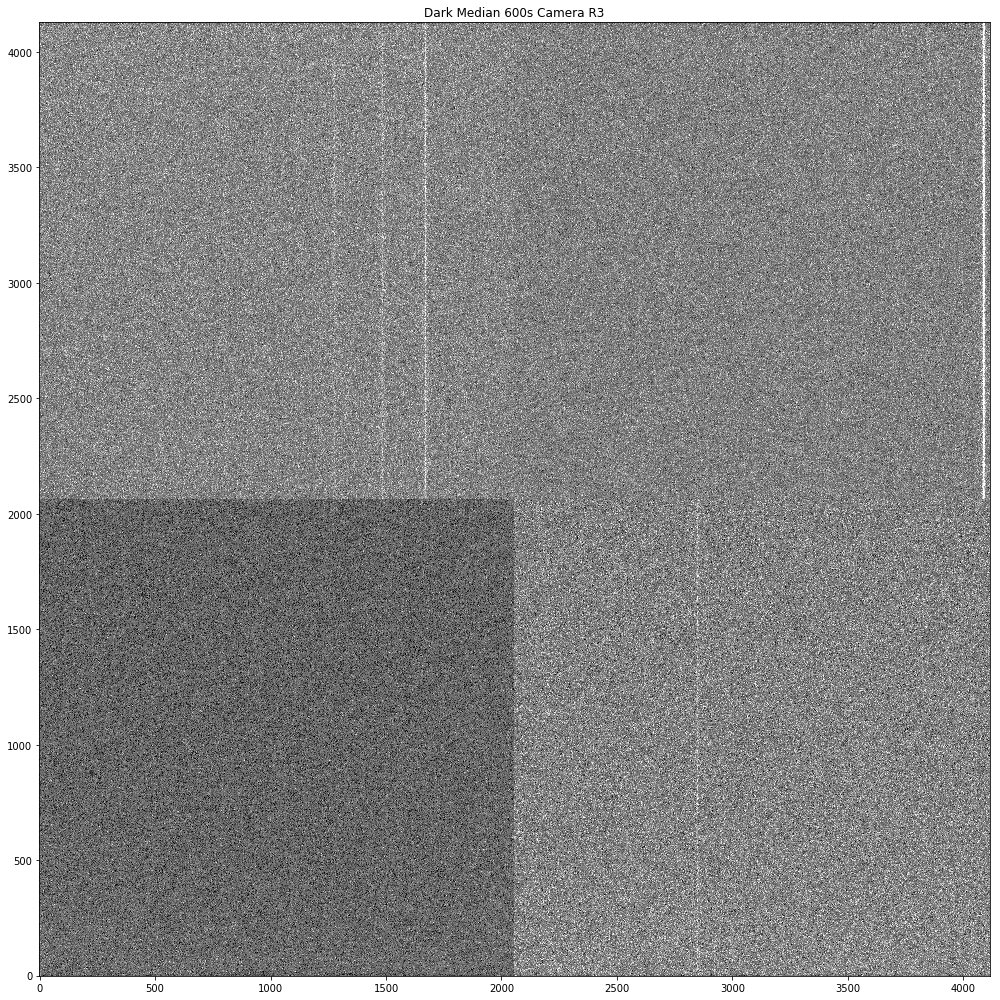

In [10]:
sup = np.zeros((4128, 4114, 1))
cam = "R3"

# Load the image, subtract the bias and concatenate it to the "super" image.
# Super image is just all the images stacked on top of each other.
for i in ims:
    print(i)
    hdus = fits.open(os.path.join(ROOT, str(d), i, f"desi-{i}.fits.fz"))
    img = hdus[cam].data
    if int(hdus[cam].header['EXPTIME']) > 0:
        img = subtract_bias(img, cam, hdus)
        temp = img.reshape(img.shape[0], img.shape[1], 1)
        sup = np.concatenate((sup, temp), axis=2)

print("Loaded")

# This is when we do the actual median, we just take a median along the "stack" axis
final = np.median(sup, axis=2)

# Display the final result!
zscale = ZScaleInterval()
norm = ImageNormalize(final, zscale)
fig, ax = plt.subplots(1, 1, figsize=(14, 14), tight_layout=True)
ax.imshow(final, cmap='gray', origin="lower", interpolation="none", norm=norm)
plt.title(f"Dark Median 600s Camera {cam}")

Num bins  191.0
Median 0.0
STD 1.28167947749
2xSTD 2.56335895497
3xSTD 3.84503843246


Text(0.5,0,'Pixel value')

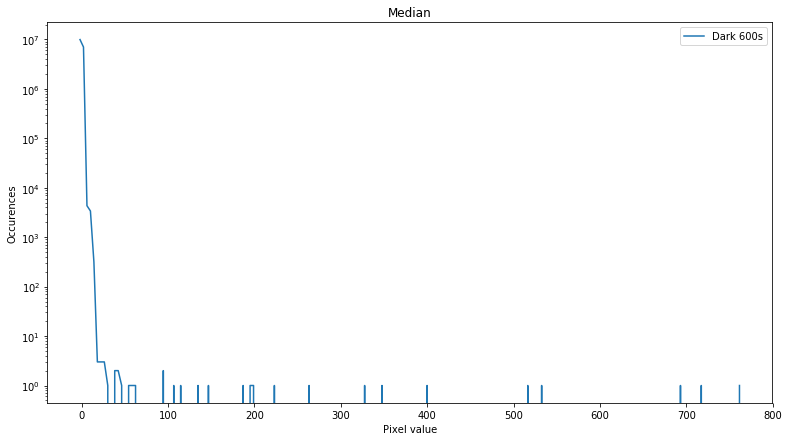

In [11]:
# Upper limit on pixel value
max_pix_val = 1200

fig, ax = plt.subplots(figsize=(13, 7))

hist_img = final[final > -5]
to_hist = hist_img[hist_img < max_pix_val].flatten()
num_bins = (to_hist.max() - to_hist.min()) // 4

# Printing the number of bins just for edification.
print("Num bins ", num_bins)

# Generate the histogram (obv lol)
n, bins = np.histogram(to_hist, bins=int(num_bins))
width = (bins[1] - bins[0]) / 2

# Smooth the histogram a bit using the following 5 item kernel
# A weighted average that considers the bin position more than
# the two adjacent bins more than the two adjacent adjacent bins.
k = np.asarray([1]) 
# k = np.asarray([1, 2, 3, 2, 1]) 
k = k / np.sum(k)
n = np.convolve(n, k, "same")
# plt.plot(bins[:-1] + width, n, label=f"{d}: {e} {sky_time}s") 
plt.plot(bins[:-1] + width, n, label=f"Dark 600s") 

print("Median", np.median(final))
print("STD", np.std(final))
print("2xSTD", 2 * np.std(final))
print("3xSTD", 3 * np.std(final))

plt.legend()
plt.yscale("log")
plt.title(f"Median")
plt.ylabel("Occurences")
plt.xlabel("Pixel value")

/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/conda/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


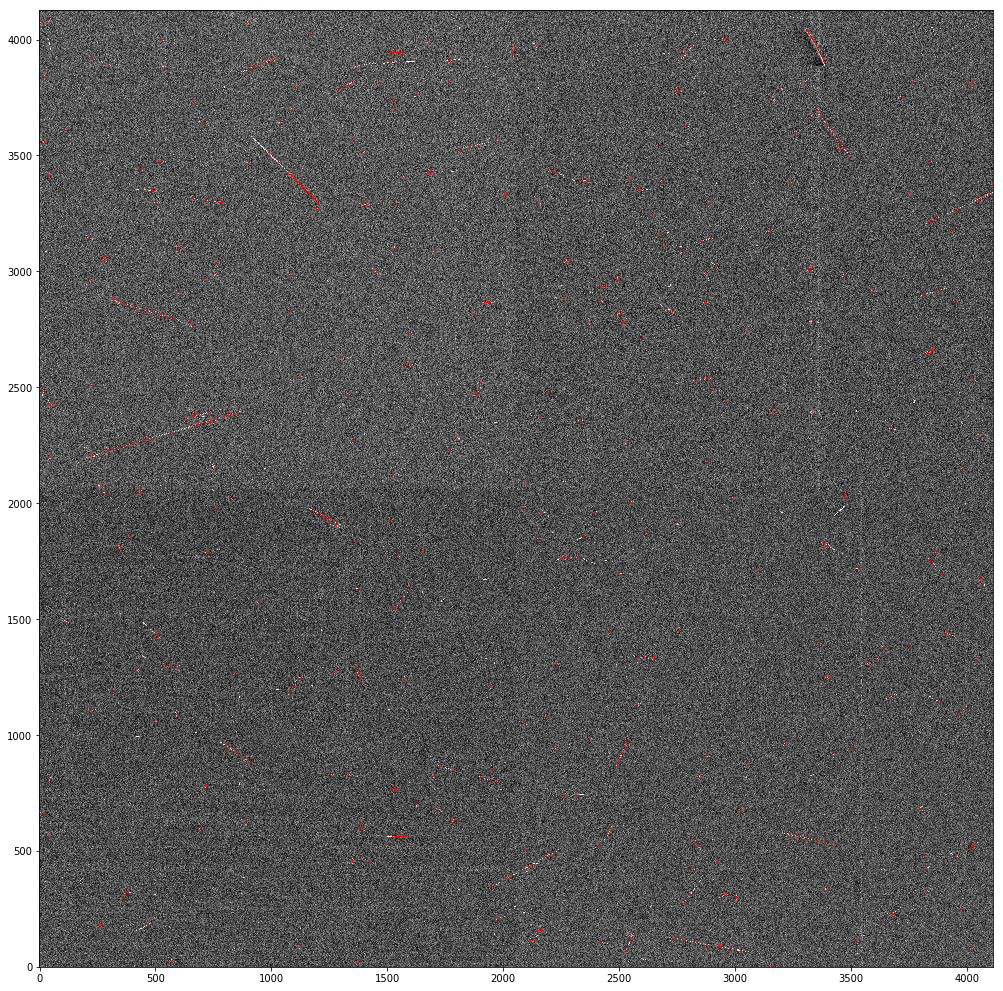

In [12]:
d, e = "20191108", "00025659"
dark_hdus = fits.open(os.path.join(ROOT, d, e, f"desi-{e}.fits.fz"))
dark_img = dark_hdus["R1"].data
dark_img = subtract_bias(dark_img, "R1", dark_hdus)

cosmic_thresh = 100
mask_img = np.ma.masked_where(dark_img > cosmic_thresh, dark_img)

cmap = cm.gray
cmap.set_bad(color="red")

zscale = ZScaleInterval()
norm = ImageNormalize(dark_img, zscale)
fig, ax = plt.subplots(1, 1, figsize=(14, 14), tight_layout=True)
ax.imshow(mask_img, cmap=cmap, origin="lower", interpolation="none", norm=norm)

In this cell I run a small loop that basically "flood fills" the cosmic outward. From the histogram analyses we have determined that above pixel value 600 all pixels are cosmic rays as it does not seem that the data gets this high. In darks there is not data, so we can use ~100 as a pixel seed value. From these individual (or multiple) pixels we expand each pixel outward using a 3x3 convolution kernel, then remove any pixels where the pixel value has fallen below the shot noise into the actual background of the dark ($3\sigma$ of the median dark). This lets us expand cosmic rays outwards from pixels we know are cosmic rays into every pixel that could reasonably be a part of this cosmic ray.

Finally we plot the new cosmic mask against the seed cosmic mask.

Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
2.616691827774048


/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/conda/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


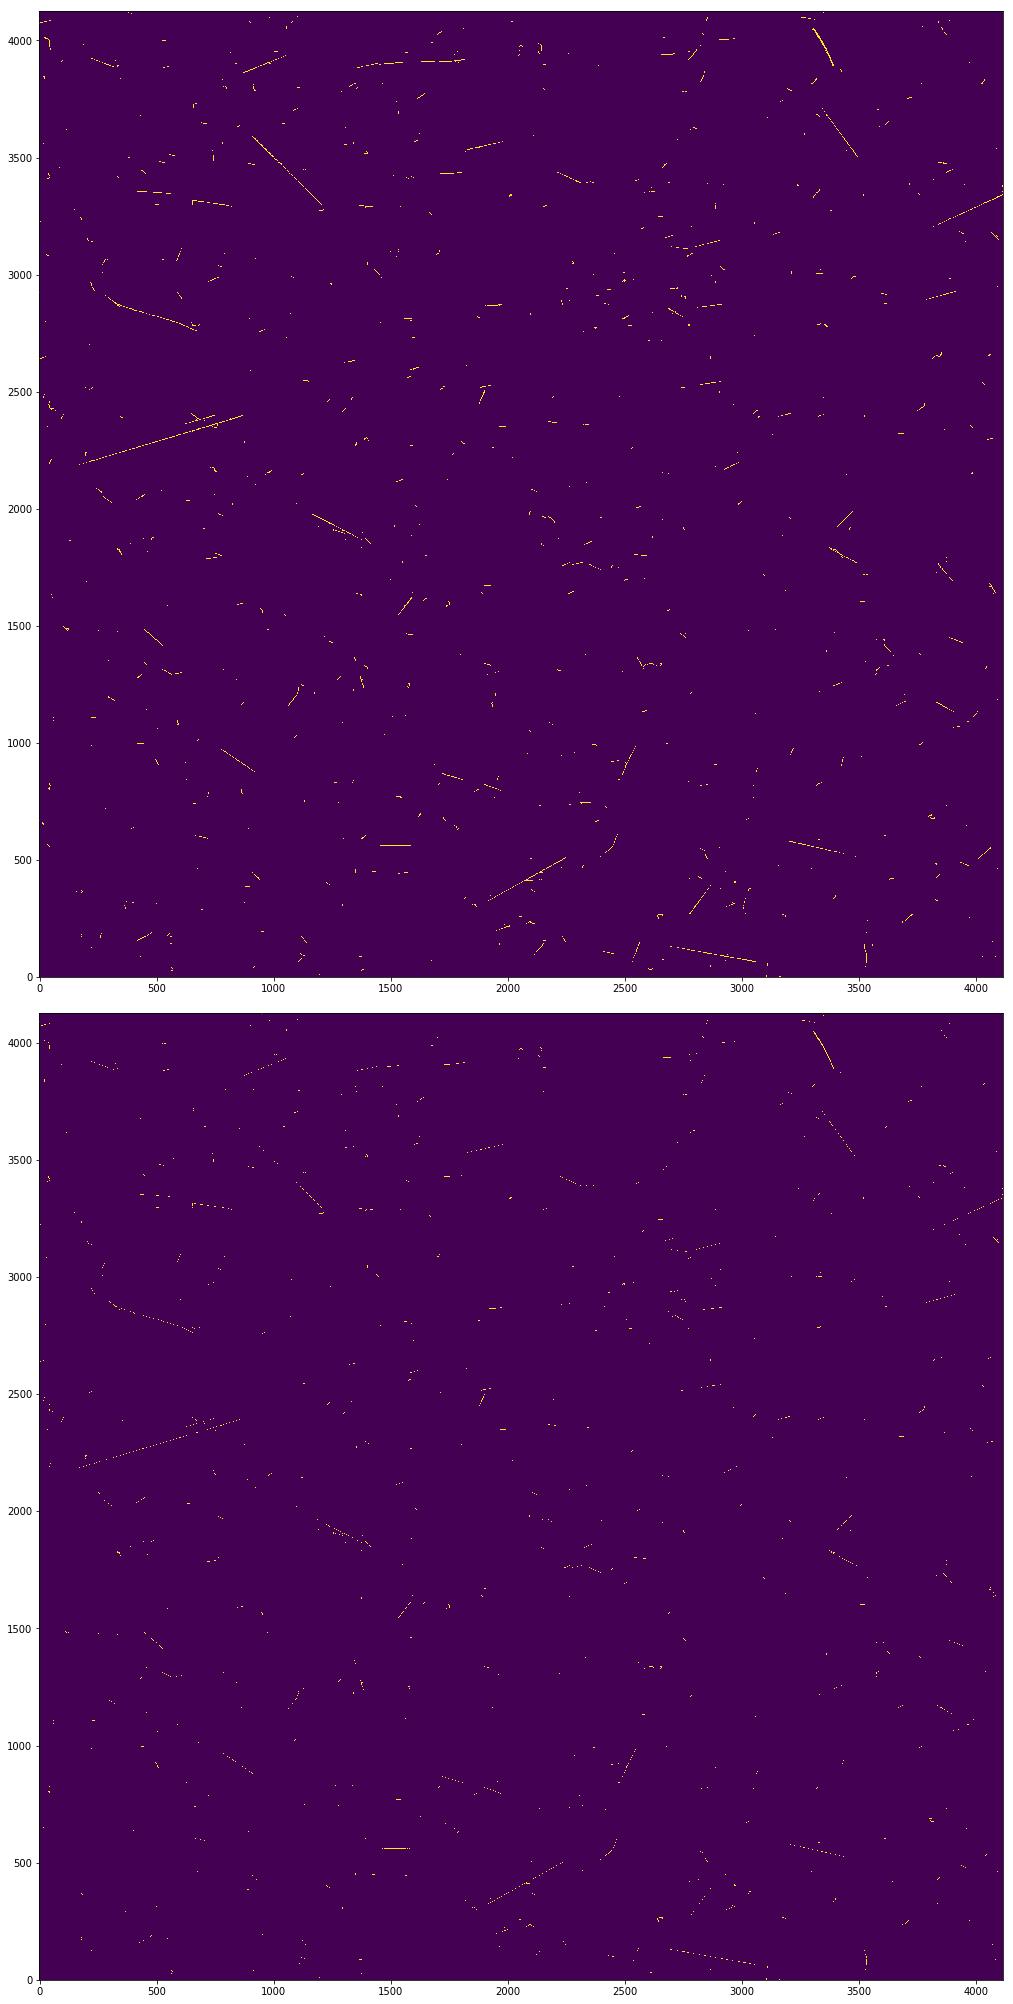

In [13]:
cosmic_thresh = 250
m = dark_img > cosmic_thresh
good = dark_img > 3 * np.std(final)

k = np.ones((3, 3))
prev = 0
i = 0
t1 = time.time()
while(np.sum(m) - prev) > 0:
    prev = np.sum(m)
    i += 1 
    print("Iteration", i)
    m = ndimage.convolve(m, k) & good
    
print(time.time() - t1)

fig, ax = plt.subplots(2, 1, figsize=(14, 28), tight_layout=True)
m1 = dark_img > cosmic_thresh
ax[0].imshow(m, origin="lower")

# zscale = ZScaleInterval()
# norm = ImageNormalize(dark_img, zscale)
ax[1].imshow(m1, origin="lower")


# ax[0].axhline(y = y_min)
# ax[0].axhline(y = y_max)
# ax[0].axvline(x = x_min)
# ax[0].axvline(x = x_max)


# ax[1].axhline(y = y_min)
# ax[1].axhline(y = y_max)
# ax[1].axvline(x = x_min)
# ax[1].axvline(x = x_max)

The above loop turned into a function.

In [14]:
def flood_cosmic(input_mask, good):
    # We don't want to actually affect the input mask.
    m = np.copy(input_mask)
    k = np.ones((3, 3))
    prev = 0
    
    # Loop over as long as no new cosmic affected pixels are added at the end of each step.
    while(np.sum(m) - prev) > 0:
        prev = np.sum(m)
        m = ndimage.convolve(m, k) & good

    return m

In [ ]:
# I rewrote this cell because it's bad practice to use try/except
# when you could just, you know, use if statements?
cam = "R3"

# For saving all of these in the next cell so we don't need to rerun this often.
exp_times = []
nums = []
cosmics = []
cosmic_masks = []
cosmic_ivar = []

for d in range(20191026, 20201108):
    
    # This will skip any dates that don't exist because observing didn't happen that night.
    exp_path = os.path.join(ROOT, str(d))
    if not os.path.isdir(exp_path):
        continue
        
    exps = os.listdir(exp_path)

    for e in exps:
        # We skip exposure dates that don't have a request file.
        # We do this because it's easier to get exp time, flavor, etc
        # wait all of this is in the file that I'm loading.
        file_exists = os.path.isfile(os.path.join(exp_path, e, "desi-" + e + ".fits.fz"))
        # There are weird cases where the file exists and the preproc doesn't. Odd.
        preproc_exists = os.path.isfile(os.path.join(ROOT_PRE, str(d), e, f"preproc-{cam.lower()}-{e}.fits"))
        if not (file_exists and preproc_exists):
            continue
        else:
            hdus = fits.open(os.path.join(exp_path, e, "desi-" + e + ".fits.fz"))
            
            # We don't need the sequence anymore since only spectrograph files are saved
            # as desi-e-.fits.fz, everything else is not (for ex GFA images are gfa-e-fits.fz)
            e_time = hdus[cam].header['EXPTIME']
            flavor = hdus[cam].header['FLAVOR']
            
            if flavor == 'dark':
                print("Adding cosmics for", d, e, e_time)
                # We load the preproced version of the image for the inverse variance
                # We only really need this to experiment with the old cosmic method.
                ivar_hdus = fits.open(os.path.join(ROOT_PRE, str(d), e, f"preproc-{cam.lower()}-{e}.fits"))

                # Load the image and subtract the bias to normalize it
                ii = hdus[cam].data
                ii2 = subtract_bias(ii, cam, hdus)

                # Join the cosmics in order to reduce the number to be closer to the true value
                print("Flooding cosmics")
                m = flood_cosmic(ii2 > cosmic_thresh, ii2 > 3 * np.std(final))
                m_binary = ndimage.convolve(m, k) # This is 50ms faster than a binary_dilation.
                m_binary = ndimage.binary_opening(m_binary, np.ones((3,3))) # Should remove hot pixels
                m_labels, num_labels = ndimage.label(m_binary, structure=np.ones((3,3)))

                # Ok so 0 is the non labeled ones so we have to start at 1
                for i in range(1, num_labels):
                    points = np.argwhere(m_labels == i)
                    
                    # We do y this way because interplay between the origin of the array being the
                    # top left of the image and the image actually being displayed in the opposite
                    # vertical orientation (origin lower left)
                    # This is also why the max is from the min and the min is from the max.
                    y_min = np.min(points[:,0])
                    y_max = np.max(points[:,0])
                    x_min = np.min(points[:,1])
                    x_max = np.max(points[:,1])

                    cosmic = ii2[y_min:y_max, x_min:x_max]
                    cosmics.append(cosmic)
                    
                    small_mask = m[y_min:y_max, x_min:x_max]
                    cosmic_masks.append(small_mask)
                    
                    # Saving the ivar for playing with the old method
                    cosmic = ivar_hdus["IVAR"].data[y_min:y_max, x_min:x_max]
                    cosmic_ivar.append(cosmic)
                print("Cosmics added, continuing.\n")
                
                # Append the relevant data to their lists for saving
                nums.append(num_labels)
                exp_times.append(e_time)
            

Adding cosmics for 20191026 00021483 1200.0
Flooding cosmics
Cosmics added, continuing.

Adding cosmics for 20191026 00021485 1200.0
Flooding cosmics
Cosmics added, continuing.

Adding cosmics for 20191026 00021482 1200.0
Flooding cosmics
Cosmics added, continuing.

Adding cosmics for 20191026 00021484 1200.0
Flooding cosmics
Cosmics added, continuing.

Adding cosmics for 20191026 00021486 1200.0
Flooding cosmics
Cosmics added, continuing.

Adding cosmics for 20191026 00021488 1200.0
Flooding cosmics
Cosmics added, continuing.

Adding cosmics for 20191026 00021487 1200.0
Flooding cosmics
Cosmics added, continuing.

Adding cosmics for 20191026 00021479 1200.0
Flooding cosmics


In [ ]:
# Saving these so we don't have to try and recreate them every time. 
# Dunno why I didn't do that earlier.
np.save("cosmic_data/cosmics", np.asarray(cosmics))
np.save("cosmic_data/cosmic_masks", np.asarray(cosmic_masks))
np.save("cosmic_data/cosmics_ivar", np.asarray(cosmic_ivar))
np.save("cosmic_data/exp", np.asarray(exp_times))
np.save("cosmic_data/nums", np.asarray(nums))

In [ ]:
d,e = "20191026", "00021481"
exp_path = os.path.join(ROOT, str(d))
hdus = fits.open(os.path.join(exp_path, e, "desi-" + e + ".fits.fz"))

ii = hdus[cam].data
ii2 = subtract_bias(ii, cam, hdus)

# Join the cosmics in order to reduce the number to be closer to the true value
print("Flooding cosmics")
m = flood_cosmic(ii2 > 250, ii2 > 3 * np.std(final))
m_binary = ndimage.convolve(m, k) # This is 50ms faster than a binary_dilation.
# m_binary = ndimage.binary_opening(m_binary, np.ones((3,3))) # Should remove hot pixels
m_labels, num_labels = ndimage.label(m_binary, structure=np.ones((3,3)))

Flooding cosmics


In [ ]:
num_labels

In [ ]:
cosmics = []
cosmic_masks = []

# Ok so 0 is the non labeled ones so we have to start at 1
for i in range(1, num_labels):
    points = np.argwhere(m_labels == i)

    # We do y this way because interplay between the origin of the array being the
    # top left of the image and the image actually being displayed in the opposite
    # vertical orientation (origin lower left)
    # This is also why the max is from the min and the min is from the max.
    # y_max = ii2.shape[0] - np.min(points[:,0])
    # y_min = ii2.shape[0] - np.max(points[:,0])
    y_min = np.min(points[:,0])
    y_max = np.max(points[:,0])
    x_min = np.min(points[:,1])
    x_max = np.max(points[:,1])

    cosmic = ii2[y_min:y_max, x_min:x_max]
    cosmics.append(cosmic)

    small_mask = m[y_min:y_max, x_min:x_max]
    cosmic_masks.append(small_mask)

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(14, 28), tight_layout=True)
m1 = dark_img > cosmic_thresh
ax[0].imshow(m_labels)

zscale = ZScaleInterval()
norm = ImageNormalize(ii2, zscale)
ax[1].imshow(ii2, norm=norm, cmap="gray")

print(y_max, y_min)

ax[0].axhline(y = y_min)
ax[0].axhline(y = y_max)
ax[0].axvline(x = x_min)
ax[0].axvline(x = x_max)

ax[1].axhline(y = y_min)
ax[1].axhline(y = y_max)
ax[1].axvline(x = x_min)
ax[1].axvline(x = x_max)

In [18]:
c = [len(i) for i in cosmics]
np.argmax(c), np.max(c)

(37045, 2067)

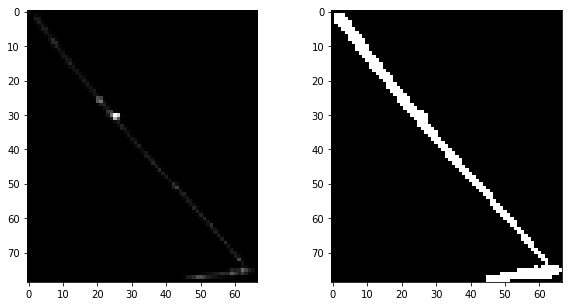

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(cosmics[37065], cmap="gray")
ax[1].imshow(cosmic_masks[37065], cmap="gray")